In [1]:
library(glmmSeq)
setwd('/lustre/scratch117/cellgen/team297/kt16/COVID_imperial_renal/')

Registered S3 methods overwritten by 'lme4':
  method                          from
  cooks.distance.influence.merMod car 
  influence.merMod                car 
  dfbeta.influence.merMod         car 
  dfbetas.influence.merMod        car 



In [2]:
load('h5ad/df.fil3_gex_bcells_vdj_sce_B_naive_deg.RData')
ls()

[1] "res1"     "res2"     "res3"     "res4"     "res5"     "results1"
 [7] "results2" "results3" "results4" "results5"

In [3]:
library(dplyr)
makeGeneList <- function(gl, beta_column='LFC'){
    y <- grepl('^RPS|^RPL|^MT-', row.names(gl))
    gl <- gl[!y, ]
    rank <- -log10(gl$pval) * sign(gl[,beta_column])
    rank[which(rank == Inf)] <- 300
    rank[which(rank == -Inf)] <- 300
    names(rank) <- row.names(gl)
    rank <- rev(sort(rank))
    gl <- rank
    return(gl)
}


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [4]:
head(results1)
dim(results1)

,fixed-effects estimates,pval,qval,LFC,Singular,Conv
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FKBP5,0.7781192,0.004126302,0.04838653,1.0156121,0,0
IL7R,0.7509679,0.012881958,0.11768518,0.8924060,0,0
TNFSF9,0.7325408,0.051208514,0.28589894,0.7420129,0,0
IFIT1,0.7135821,0.177829903,0.52409513,0.9407787,0,0
CPT1A,0.6554450,0.002964296,0.03597060,0.8388903,0,0
UACA,0.6348857,0.010508109,0.10119556,0.8090985,0,0


[1] 8671    6

In [5]:
head(results2)
dim(results2)

,fixed-effects estimates_linear,fixed-effects estimates_quadratic,pval,qval,Singular,Conv
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SCARB1,-0.2297640,1.279857,0.04571106,0.16200538,0,0
FAM111B,1.9492013,1.267743,0.33955010,0.57437521,0,0
CPT1A,1.0596729,1.244703,0.10205995,0.27848126,0,0
SPAG16,-0.9719379,1.193210,0.01189632,0.05781642,0,0
XIST,1.4971372,1.184375,0.67037094,0.81802226,0,0
CKS2,2.2589233,1.175909,0.04566221,0.16193748,0,0


[1] 6424    6

In [6]:
head(results3)
dim(results3)

,fixed-effects estimates,pval,qval,LFC,Singular,Conv
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
IFIT1,2.296720,9.924496e-05,0.007137633,2.388642,0,0
USP18,1.869896,2.975542e-04,0.020894399,1.944549,0,0
IFI44L,1.565686,8.500801e-04,0.058315498,2.169493,0,0
OAS3,1.481316,1.988509e-03,0.130393526,1.730105,0,0
RSAD2,1.472741,3.107544e-03,0.197950564,1.466231,0,0
OASL,1.385387,1.761591e-02,0.729708749,1.210466,0,0


[1] 8720    6

In [7]:
head(results4)
dim(results4)

,fixed-effects estimates,pval,qval,LFC,Singular,Conv
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DSP,1.0796280,0.0107412612,0.032528011,1.3542152,0,0
CNTNAP2,0.9242893,0.0095356203,0.029904630,1.2340652,0,0
IGHG3,0.8891763,0.0518854348,0.103577123,1.0495421,0,0
NETO1,0.8680128,0.0631007345,0.119764447,0.9286125,0,0
TXNDC5,0.7979857,0.0029580199,0.012360793,1.0726148,0,0
MXI1,0.7812591,0.0001180712,0.001100946,1.0908005,0,0


[1] 102   6

In [8]:
head(results5)
dim(results5)

,fixed-effects estimates,pval,qval,LFC,Singular,Conv
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
EIF2AK2,1.874257,6.916549e-10,6.830901e-09,2.611070,0,0
IFIT2,1.667143,2.321399e-05,6.609324e-05,2.112843,0,0
LY6E-DT,1.635279,9.652144e-05,2.299557e-04,1.593480,0,0
PARP9,1.553918,2.330054e-07,1.146760e-06,2.099018,0,0
AC116407.2,1.451315,2.338666e-04,4.984379e-04,1.524453,0,0
RASL11A,1.432831,3.089570e-03,4.914401e-03,1.088521,0,0


[1] 7640    6

In [9]:
library(fgsea)
library(msigdbr)

In [10]:
h <- data.frame(msigdbr::msigdbr(category = "H", species = 'Homo sapiens'))
h <- split(h, h$gs_name)
h <- lapply(h, function(x) x %>% dplyr::select(gene_symbol) %>% unlist %>% as.character)

In [32]:
plotGSEA_Hallmark <- function(gsea, fdr_cutoff = 0.05, cols = NULL, xlim = NULL, newlabels = NULL, keep_significant_only = TRUE, jitter = FALSE) {
    require(ggplot2)
    gsea$NES[which(is.na(gsea$NES))] <- 0
    gsea$pval[which(is.na(gsea$pval))] <- 1
    gsea$padj[which(is.na(gsea$padj))] <- 1
    gsea$ranking[which(is.na(gsea$ranking))] <- 0
    gsea <- gsea[order(gsea$ranking),]
    
    if (keep_significant_only){
        gseax <- split(gsea, gsea$pathway)
        for (i in 1:length(gseax)){
            if (all(gseax[[i]]$pval >= 0.05)|all(gseax[[i]]$padj >=fdr_cutoff)){
                gseax[[i]] <- NA        
            }
        }
        gseax <- gseax[!is.na(gseax)]
        gsea <- do.call(rbind, gseax)        
    }
    if (!is.null(gsea)){
        gsea <- gsea[order(gsea$ranking), ]
        gsea$pathway <- gsub("HALLMARK_|", "", gsea$pathway)

        if (!is.null(xlim)){
            x_lim_min = -xlim
            x_lim_max = xlim
        } else {
            x_lim_min <- abs(ceiling(min(-log10(gsea$padj))))
            x_lim_max <- abs(ceiling(max(-log10(gsea$padj))))
        }
        
        if(x_lim_min > x_lim_max){
            xval1 <- x_lim_min * -1
            xval2 <- x_lim_min
        } else {
            xval1 <- x_lim_max * -1
            xval2 <- x_lim_max
        }

        if(!is.null(cols)){
            gg_color_hue <- function(n) {
                hues = seq(15, 375, length = n + 1)
                hcl(h = hues, l = 65, c = 100)[1:n]
            }
            cols. = gg_color_hue(dplyr::n_distinct(gsea$group, na.rm = TRUE))
        } else {
            cols. = cols
        }    
    
        g <- ggplot(gsea, aes(x = -log10(padj)*sign(NES), y = reorder(pathway, ranking), col = -log10(padj)*sign(NES), size = abs(NES)))
        if (jitter){
            g <- g + geom_point(position = 'jitter')
        }else{
            g <- g + geom_point()
        }
        g <- g + theme_bw() +
            labs(x = expression(paste("Signed", " -log" ["10"], "adjusted pval")), y = "Hallmarks") +
            scale_color_gradient2(low = '#2166ac', mid = '#f7f7f7', high = '#b2182b', na.value = NA, limits = c(-2,2), oob = scales::squish) +
            geom_vline(xintercept = 0) +
            geom_vline(xintercept = -log10(fdr_cutoff), colour = '#ff7f0e') +
            geom_vline(xintercept = -log10(fdr_cutoff)*-1, colour = '#ff7f0e') +
            scale_x_continuous(limits = c(xval1, xval2), oob = scales::squish) +
            scale_size_area(oob = scales::squish, max_size = 3, limits = c(0,2)) +
            theme(panel.grid.major = element_blank(), 
                panel.grid.minor = element_blank(), 
                panel.background = element_blank(), 
                axis.line = element_blank(), 
                axis.ticks = element_blank(),
                axis.text = element_text(color = 'black'),
                axis.title = element_text(color = 'black'),
                legend.direction = "vertical", legend.box = "horizontal"
                )
        
        return(g)
    }
}

Warning message in fgseaMultilevel(...):
“There were 2 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple = 10000)”


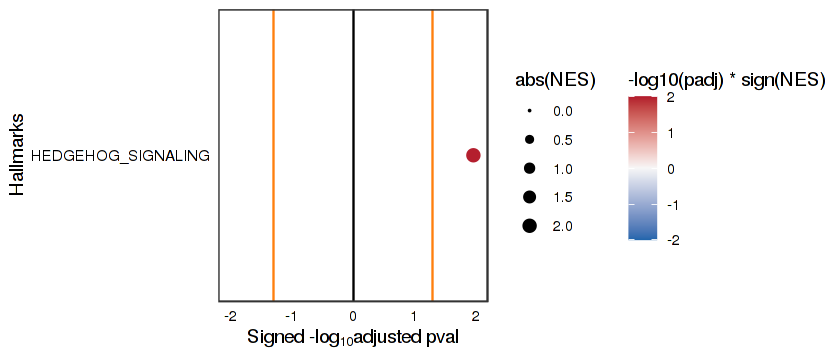

In [33]:
options(repr.plot.height = 3)
gl1 <- makeGeneList(results1)
res1gsea <- fgsea(pathways = h, stats = gl1, minSize = 0, maxSize =1000)
res1gsea$ranking <- -log10(res1gsea$pval) * sign(res1gsea$NES)
plotGSEA_Hallmark(res1gsea)

In [34]:
# gl2 <- makeGeneList(results2, 'fixed-effects estimates_linear')
# res2gsea <- fgsea(pathways = h, stats = gl2, minSize = 0, maxSize =1000)
# res2gsea$ranking <- -log10(res2gsea$pval) * sign(res2gsea$NES)
# plotGSEA_Hallmark(res2gsea)

In [35]:
# gl2 <- makeGeneList(results2, 'fixed-effects estimates_quadratic')
# res2gsea <- fgsea(pathways = h, stats = gl2, minSize = 0, maxSize =1000)
# res2gsea$ranking <- -log10(res2gsea$pval) * sign(res2gsea$NES)
# plotGSEA_Hallmark(res2gsea)

Warning message in fgseaMultilevel(...):
“There were 1 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple = 10000)”
Warning message in fgseaMultilevel(...):
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”


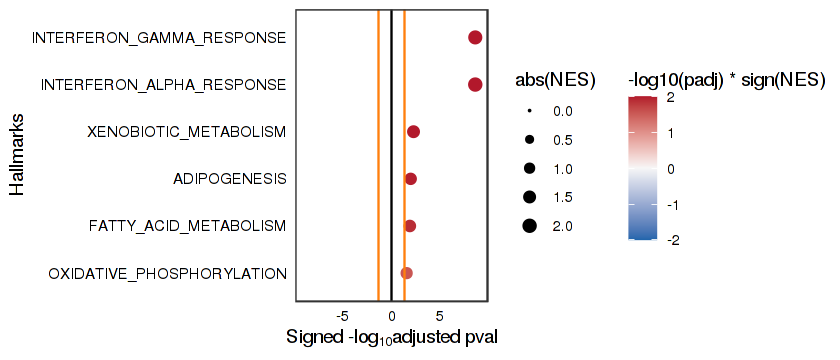

In [36]:
options(repr.plot.height = 3)
gl3 <- makeGeneList(results3)
res3gsea <- fgsea(pathways = h, stats = gl3, minSize = 0, maxSize =1000)
res3gsea$ranking <- -log10(res3gsea$pval) * sign(res3gsea$NES)
plotGSEA_Hallmark(res3gsea)

In [37]:
options(repr.plot.height = 4)
gl4 <- makeGeneList(results4)
res4gsea <- fgsea(pathways = h, stats = gl4, minSize = 0, maxSize =1000)
res4gsea$ranking <- -log10(res4gsea$pval) * sign(res4gsea$NES)
plotGSEA_Hallmark(res4gsea)

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“All values in the stats vector are greater than zero and scoreType is "std", maybe you should switch to scoreType = "pos".”


Warning message in fgseaMultilevel(...):
“There were 1 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple = 10000)”
Warning message in fgseaMultilevel(...):
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”


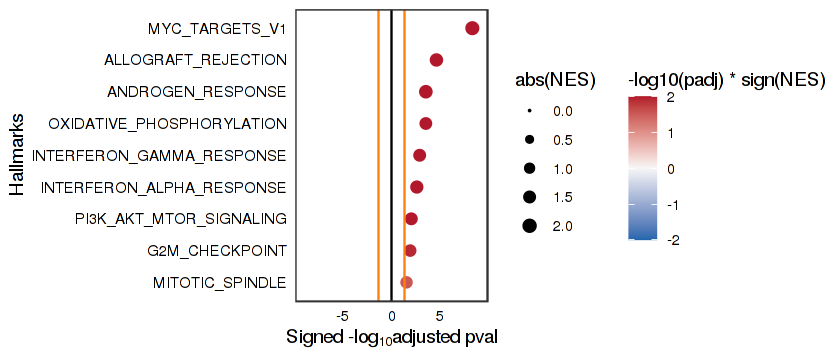

In [38]:
options(repr.plot.height = 3)
gl5 <- makeGeneList(results5)
res5gsea <- fgsea(pathways = h, stats = gl5, minSize = 0, maxSize =1000)
res5gsea$ranking <- -log10(res5gsea$pval) * sign(res5gsea$NES)
plotGSEA_Hallmark(res5gsea)